In [122]:
import torch

<a href="https://arxiv.org/pdf/2009.13015.pdf">Cloud Removal for Remote Sensing Imagery
vai Spatial Attention Generative Adversarial Network</a>

In [123]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)




###### Layer 
def conv1x1(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels,out_channels,kernel_size = 1,
                    stride =stride, padding=0,bias=False)

def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels,out_channels,kernel_size = 3,
        stride =stride, padding=1,bias=False)

class Bottleneck(nn.Module):
    def __init__(self,in_channels,out_channels,):
        super(Bottleneck,self).__init__()
        m  = OrderedDict()
        m['conv1'] = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        m['relu1'] = nn.ReLU(True)
        m['conv2'] = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=2, bias=False,dilation=2)
        m['relu2'] = nn.ReLU(True)
        m['conv3'] = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)
        self.group1 = nn.Sequential(m)
        self.relu= nn.Sequential(nn.ReLU(True))

    def forward(self, x):
        out = self.group1(x) 
        return out

class irnn_layer(nn.Module):
    def __init__(self,in_channels):
        super(irnn_layer,self).__init__()
        self.left_weight = nn.Conv2d(in_channels,in_channels,kernel_size=1,stride=1,groups=in_channels,padding=0)
        self.right_weight = nn.Conv2d(in_channels,in_channels,kernel_size=1,stride=1,groups=in_channels,padding=0)
        self.up_weight = nn.Conv2d(in_channels,in_channels,kernel_size=1,stride=1,groups=in_channels,padding=0)
        self.down_weight = nn.Conv2d(in_channels,in_channels,kernel_size=1,stride=1,groups=in_channels,padding=0)
        
    def forward(self,x):
        _,_,H,W = x.shape
        top_left = x.clone()
        top_right = x.clone()
        top_up = x.clone()
        top_down = x.clone()
        top_left[:,:,:,1:] = F.relu(self.left_weight(x)[:,:,:,:W-1]+x[:,:,:,1:],inplace=False)
        top_right[:,:,:,:-1] = F.relu(self.right_weight(x)[:,:,:,1:]+x[:,:,:,:W-1],inplace=False)
        top_up[:,:,1:,:] = F.relu(self.up_weight(x)[:,:,:H-1,:]+x[:,:,1:,:],inplace=False)
        top_down[:,:,:-1,:] = F.relu(self.down_weight(x)[:,:,1:,:]+x[:,:,:H-1,:],inplace=False)
        return (top_up,top_right,top_down,top_left)


class Attention(nn.Module):
    def __init__(self,in_channels):
        super(Attention,self).__init__()
        self.out_channels = int(in_channels/2)
        self.conv1 = nn.Conv2d(in_channels,self.out_channels,kernel_size=3,padding=1,stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.out_channels,self.out_channels,kernel_size=3,padding=1,stride=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(self.out_channels,4,kernel_size=1,padding=0,stride=1)
        self.sigmod = nn.Sigmoid()
    
    def forward(self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)
        out = self.sigmod(out)
        return out


class SAM(nn.Module):
    def __init__(self,in_channels,out_channels,attention=1):
        super(SAM,self).__init__()
        self.out_channels = out_channels
        self.irnn1 = irnn_layer(self.out_channels)
        self.irnn2 = irnn_layer(self.out_channels)
        self.conv_in = conv3x3(in_channels,self.out_channels)
        self.relu1 = nn.ReLU(True)
        
        self.conv1 = nn.Conv2d(self.out_channels,self.out_channels,kernel_size=1,stride=1,padding=0)
        self.conv2 = nn.Conv2d(self.out_channels*4,self.out_channels,kernel_size=1,stride=1,padding=0)
        self.conv3 = nn.Conv2d(self.out_channels*4,self.out_channels,kernel_size=1,stride=1,padding=0)
        self.relu2 = nn.ReLU(True)
        self.attention = attention
        if self.attention:
            self.attention_layer = Attention(in_channels)
        self.conv_out = conv1x1(self.out_channels,1)
        self.sigmod = nn.Sigmoid()
    
    def forward(self,x):
        if self.attention:
            weight = self.attention_layer(x)
        out = self.conv1(x)
        top_up,top_right,top_down,top_left = self.irnn1(out)
        
        # direction attention
        if self.attention:
            top_up.mul(weight[:,0:1,:,:])
            top_right.mul(weight[:,1:2,:,:])
            top_down.mul(weight[:,2:3,:,:])
            top_left.mul(weight[:,3:4,:,:])
        out = torch.cat([top_up,top_right,top_down,top_left],dim=1)
        out = self.conv2(out)
        top_up,top_right,top_down,top_left = self.irnn2(out)
        
        # direction attention
        if self.attention:
            top_up.mul(weight[:,0:1,:,:])
            top_right.mul(weight[:,1:2,:,:])
            top_down.mul(weight[:,2:3,:,:])
            top_left.mul(weight[:,3:4,:,:])
        
        out = torch.cat([top_up,top_right,top_down,top_left],dim=1)
        out = self.conv3(out)
        out = self.relu2(out)
        mask = self.sigmod(self.conv_out(out))
        return mask

###### Network
class SPANet(nn.Module):
    def __init__(self):
        super(SPANet,self).__init__()

        self.conv_in = nn.Sequential(
            conv3x3(3,32),
            nn.ReLU(True)
            )
        self.SAM1 = SAM(32,32,1)
        self.res_block1 = Bottleneck(32,32)
        self.res_block2 = Bottleneck(32,32)
        self.res_block3 = Bottleneck(32,32)
        self.res_block4 = Bottleneck(32,32)
        self.res_block5 = Bottleneck(32,32)
        self.res_block6 = Bottleneck(32,32)
        self.res_block7 = Bottleneck(32,32)
        self.res_block8 = Bottleneck(32,32)
        self.res_block9 = Bottleneck(32,32)
        self.res_block10 = Bottleneck(32,32)
        self.res_block11 = Bottleneck(32,32)
        self.res_block12 = Bottleneck(32,32)
        self.res_block13 = Bottleneck(32,32)
        self.res_block14 = Bottleneck(32,32)
        self.res_block15 = Bottleneck(32,32)
        self.res_block16 = Bottleneck(32,32)
        self.res_block17 = Bottleneck(32,32)
        self.conv_out = nn.Sequential(
            conv3x3(32,3)
        )
    def forward(self, x):

        out = self.conv_in(x)
        out = F.relu(self.res_block1(out) + out)
        out = F.relu(self.res_block2(out) + out)
        out = F.relu(self.res_block3(out) + out)
        
        Attention1 = self.SAM1(out) 
        out = F.relu(self.res_block4(out) * Attention1  + out)
        out = F.relu(self.res_block5(out) * Attention1  + out)
        out = F.relu(self.res_block6(out) * Attention1  + out)
        
        Attention2 = self.SAM1(out) 
        out = F.relu(self.res_block7(out) * Attention2 + out)
        out = F.relu(self.res_block8(out) * Attention2 + out)
        out = F.relu(self.res_block9(out) * Attention2 + out)
        
        Attention3 = self.SAM1(out) 
        out = F.relu(self.res_block10(out) * Attention3 + out)
        out = F.relu(self.res_block11(out) * Attention3 + out)
        out = F.relu(self.res_block12(out) * Attention3 + out)
        
        Attention4 = self.SAM1(out) 
        out = F.relu(self.res_block13(out) * Attention4 + out)
        out = F.relu(self.res_block14(out) * Attention4 + out)
        out = F.relu(self.res_block15(out) * Attention4 + out)
        
        out = F.relu(self.res_block16(out) + out)
        out = F.relu(self.res_block17(out) + out)
       
        out = self.conv_out(out)

        return Attention4 , out

class Generator(nn.Module):
    def __init__(self, gpu_ids):
        super().__init__()
        self.gpu_ids = gpu_ids

        self.gen = nn.Sequential(OrderedDict([('gen', SPANet())]))

        self.gen.apply(weights_init)

    def forward(self, x):
        if self.gpu_ids:
            return nn.parallel.data_parallel(self.gen, x, self.gpu_ids)
        else:
            return self.gen(x)

In [124]:
model = Generator(None)

In [125]:
PATH = 'gen_model_epoch_200.pth'

In [126]:
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()
model

Generator(
  (gen): Sequential(
    (gen): SPANet(
      (conv_in): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
      )
      (SAM1): SAM(
        (irnn1): irnn_layer(
          (left_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
          (right_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
          (up_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
          (down_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
        )
        (irnn2): irnn_layer(
          (left_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
          (right_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
          (up_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
          (down_weight): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), groups=32)
        )
       

In [127]:
img_pth = 'Images/Image 2013_7_sharpend_.png'
x = cv2.imread(img_pth, 1).astype(np.float32)
x.shape

#if transform:
#    x = transform(x)

#x = x.transpose(2, 0, 1)

(1560, 2112, 3)

In [128]:
x = x.transpose(2, 0, 1)
x.shape

(3, 1560, 2112)

In [173]:
from torch.utils import data
import torchvision.transforms as transforms
import cv2
import os
import numpy as np

transform_test = transforms.Compose([
                                         transforms.ToTensor(),
                                         #transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                                         #                    [0.5,0.5,0.5])
])


class Dataset(data.Dataset):
    def __init__(self, test_dir, transform=None):
        super().__init__()
        self.test_dir = test_dir
        self.test_files = os.listdir(test_dir)
        self.transform = transform
    def __len__(self):

        return len(self.test_files)

    def __getitem__(self, index):
        filename = os.path.basename(self.test_files[index])
        
        # Read as (width, height, layers(3 R,G,B))
        x = cv2.imread(os.path.join(self.test_dir, filename), 1).astype(np.float32)
        
        # Convert to (layers, Width, Height)
        #x = x.transpose(2, 0, 1)
        
        x = x / 255.
        
        if self.transform:
            x = self.transform(x)
        

        return x, filename



In [174]:
dataset = Dataset('Images', transform = transform_test)
image, _ = dataset[0]

In [175]:
image.shape

torch.Size([3, 1560, 2112])

In [176]:
image_np = np.array(image)
np.min(image_np), np.max(image_np)

(0.0, 1.0)

In [177]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

/Users/davidrestrepo/opt/anaconda3/envs/Dengue_ML_GIS_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


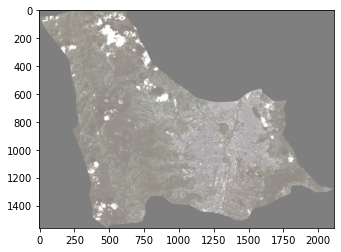

In [178]:
imshow(torch.tensor(image))

In [179]:
training_data_loader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)

In [180]:
with torch.no_grad():
    for index, (images, _) in enumerate(training_data_loader):
        # calculate outputs by running images through the network
        outputs = model(images)
        print(f'iteration: {index}')
        if (index == 0):
            break

iteration: 0


In [181]:
with torch.no_grad():
    #outs = [t.numpy() for t in outputs]
    outs = [t for t in outputs]
type(outs[1])

torch.Tensor

In [182]:
outs[0].shape

torch.Size([1, 1, 1560, 2112])

In [183]:
outs[1].shape

torch.Size([1, 3, 1560, 2112])

In [184]:
outs[1].min().item(), outs[1].max().item()

(-0.3288581371307373, 1.3214199542999268)

In [185]:
#out_img = outs[1].view((outs[1].shape[1], outs[1].shape[2], outs[1].shape[3])
out_img = np.array(outs[1]).reshape((outs[1].shape[1], outs[1].shape[2], outs[1].shape[3]))
out_img.shape

(3, 1560, 2112)

In [186]:
import matplotlib.pyplot as plt
def imshow(img):
    
    # Normalize (0-1)
    #img = img + img.min().item()
    #img = img / img.max().item()
    
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


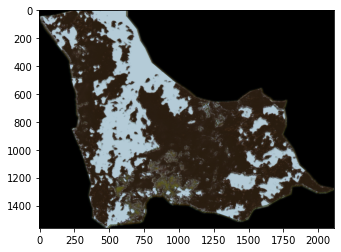

In [187]:
imshow(torch.tensor(out_img))